In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from natsort import natsorted
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.cm as cm
from pygam import LinearGAM, s, f
from scipy import stats
sns.set(font_scale=1.5, style="white")

In [2]:
df = pd.read_csv('../../Dataset/rna/brodmann_schaefer_0.5.csv')

In [3]:
regionname = pd.read_csv('../../Modules/human/schaefer400_regions.csv')
sarank = pd.read_csv('../../Modules/human/Sensorimotor_Association_Axis_AverageRanks.csv')
sarank = pd.concat([regionname.reset_index(drop=True), sarank.reset_index(drop=True)],axis=1)
sarank = sarank.loc[:, ['name', 'finalrank.wholebrain']]

In [4]:
# project directory
data_dir = '../../Modules/human/rna'
# read expression data
gene_columns = pd.read_csv(os.path.join(data_dir, 'columns_metadata.csv'))
gene_rows = pd.read_csv(os.path.join(data_dir, 'rows_metadata.csv'))
gene_columns['id'] = range(1, len(gene_columns) + 1)
expr_matrix = pd.read_csv(os.path.join(data_dir, 'expression_matrix.csv'), header=None)
expr_matrix = expr_matrix.iloc[:, 1:] 

In [5]:
# remove genes without an entrez id
expr_subset = expr_matrix[~gene_rows['entrez_id'].isna()]
rows_subset = gene_rows[~gene_rows['entrez_id'].isna()]

In [6]:
log2_expr = np.log2(expr_subset + 1)
log2_expr['entrez_id'] = rows_subset['entrez_id']

In [7]:
markers  = ['PVALB', 'SST','GAD1', 'GAD2', 'DLX1', 'DLX2'] #PVALB
for marker in markers:
    ids = gene_rows[gene_rows.gene_symbol==marker].entrez_id.values[0]
    df_marker = log2_expr[log2_expr.entrez_id==ids].iloc[:, :-1].T.values
    gene_columns[marker] = df_marker

In [8]:
sa_cortex = np.unique([x for x in gene_columns.structure_name if 'cortex' in x])
sa_cortex = pd.DataFrame([x for x in sa_cortex if 'cereb' not in x])
sa_cortex.columns = ['structure_name']

In [9]:
adults = [ '18 yrs', '19 yrs', '21 yrs','23 yrs']
cbpd_wide = ['3 yrs','4 yrs', '8 yrs', '11 yrs','13 yrs']

In [10]:
brodregion = pd.read_csv('../dataset/rna/brodmann.csv')
saorder = pd.DataFrame([np.arange(11), ['Visual', 'Auditory', 'Sensory', 'Motor', 'IPC', 'STC', 'vPFC', 'dPFC', 'OFC', 'TEv', 'ACC']]).T
saorder.columns = ['sa', 'group']
pd.merge(brodregion.iloc[:, :2], saorder, on='group', how='left').to_csv('../dataset/rna/brodmann.csv', index=False)

In [11]:
child_original = pd.read_csv('../../Derivatives/childhood/original.csv')
adult_original = pd.read_csv('../../Derivatives/adult/original.csv')

Visual = [x for x in df.columns if 'BA17' in x]
Auditory = [x for x in df.columns if 'BA41' in x]
Sensory =  [x for x in df.columns if 'BA1_3' in x] + [x for x in df.columns if 'BA2' in x] # [x for x in sarank.name.values if 'S2' in x] +
Motor = [x for x in df.columns if 'BA4' in x]
vPFC = [x for x in df.columns if 'BA44' in x] +  [x for x in df.columns if 'BA45' in x]
dPFC = [x for x in df.columns if 'BA8' in x] + [x for x in df.columns if 'BA9' in x] + [x for x in df.columns if 'BA46' in x]
OFC = [x for x in df.columns if 'BA11' in x] + [x for x in df.columns if 'BA12' in x]+ [x for x in df.columns if 'BA13' in x]  + [x for x in df.columns if 'BA14_' in x]
TEv = [x for x in df.columns if 'BA20' in x]
ACC = [x for x in df.columns if 'BA24' in x] + [x for x in df.columns if 'BA25' in x] + [x for x in df.columns if 'BA32' in x]
STC = [x for x in df.columns if 'BA22' in x]
IPC = [x for x in df.columns if 'BA39' in x] +  [x for x in df.columns if 'BA40' in x]

child_regions = []
adult_regions = []
sas = []
for x in [Sensory, Auditory, Motor, Visual, vPFC, dPFC, OFC, TEv, ACC, STC, IPC]:
    print(x)
    roi  = df.loc[:, x].sum(axis=1)>0
    #if x == ['BA41_42_52']:
    #    roi[44] = True
    child_original['roi']=roi
    adult_original['roi']=roi
    child_regions.append(child_original[child_original.roi==True].mean()['H'])
    adult_regions.append(adult_original[adult_original.roi==True].mean()['H'])
    sas.append(child_original[child_original.roi==True].mean()['SArank'])

['BA1_3', 'BA2', 'BA20', 'BA21', 'BA22', 'BA23', 'BA24', 'BA25', 'BA26_29_30', 'BA27', 'BA28']
['BA41_42_52']
['BA4', 'BA40', 'BA41_42_52', 'BA43', 'BA44', 'BA45', 'BA46', 'BA47']
['BA17']
['BA44', 'BA45']
['BA8', 'BA9', 'BA46']
['BA11', 'BA13']
['BA20']
['BA24', 'BA25', 'BA32']
['BA22']
['BA39', 'BA40']


In [13]:
child = pd.DataFrame([['Sensory', 'Auditory', 'Motor', 'Visual', 'vPFC', 'dPFC', 'OFC', 'TEv', 'ACC', 'STC', 'IPC'], child_regions, sas]).T.sort_values(2).reset_index(drop=True)
child.columns = ['region', 'H', 'sa']
adult = pd.DataFrame([['Sensory', 'Auditory', 'Motor', 'Visual', 'vPFC', 'dPFC', 'OFC', 'TEv', 'ACC', 'STC', 'IPC'], adult_regions, sas]).T.sort_values(2).reset_index(drop=True)
adult.columns = ['region', 'H', 'sa']

In [14]:
sa_cortex['region'] = ['ACC', 'dPFC', 'TEv', '-', 'OFC', '-', 'STC', 'IPC', 'Auditory', 'Motor', '-', 'Sensory', 'Visual', '-', 'vPFC']
sa_cortex = pd.merge(sa_cortex.loc[:, ['structure_name', 'region']], child.loc[:, ['region', 'sa']], on='region', how='left')

In [15]:
gene_columns = pd.merge(gene_columns,sa_cortex, on='structure_name', how='left')

In [17]:
wide = gene_columns.loc[[x for x in gene_columns.index if gene_columns.loc[x,'age'] in adults], :]
wide = wide[wide.sa>-1].sort_values('sa')
wide = wide.groupby(['sa', 'donor_name']).mean().reset_index()
wide_mean = wide.groupby(['sa']).mean().reset_index()
wide_std = wide.groupby(['sa']).sem().reset_index()

/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0.3997132613999479
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     5.993
Date:                Fri, 02 Feb 2024   Prob (F-statistic):             0.0369
Time:                        05:40:01   Log-Likelihood:                 25.223
No. Observations:                  11   AIC:                            -46.45
Df Residuals:                       9   BIC:                            -45.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6789      0.214 

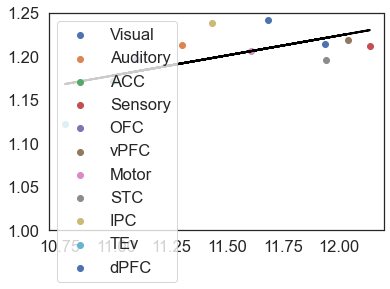

In [28]:
for i in np.arange(11):
    plt.scatter(wide_mean['PVALB'].values[i]+wide_mean['SST'].values[i], adult['H'].values[i])
#plt.legend(['Sensory', 'Auditory', 'Motor', 'Visual', 'vPFC', 'dPFC', 'OFC', 'TEv', 'ACC', 'STC', 'IPC'])
plt.legend(adult.region.values)
df_x = pd.DataFrame(wide_mean['PVALB'].values+wide_mean['SST'].values)
df_y = pd.DataFrame(adult['H'].values)
mod = LinearRegression()
mod_lin = mod.fit(df_x, df_y)
y_lin_fit = mod_lin.predict(df_x)
r2_lin = mod.score(df_x, df_y)
plt.plot(df_x, y_lin_fit, color = '#000000', linewidth=2)
print(r2_lin)
X = sm.add_constant(wide_mean['PVALB'].values+wide_mean['SST'].values)
results = sm.OLS([float(x) for x in adult['H'].values], X).fit()
print(results.summary())
plt.ylim([1.0,1.25])
plt.xlim([10.7,12.2])
#plt.savefig('../figures/Fig2_adultPV+SST.eps',  format='eps', bbox_inches='tight')

In [22]:
wide = gene_columns.loc[[x for x in gene_columns.index if gene_columns.loc[x,'age'] in cbpd_wide], :]
wide = wide[wide.sa>-1].sort_values('sa')
wide = wide.groupby(['sa', 'donor_name']).mean().reset_index()
wide_mean = wide.groupby(['sa']).mean().reset_index()
wide_std = wide.groupby(['sa']).sem().reset_index()

0.4937450566779994
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     8.778
Date:                Fri, 02 Feb 2024   Prob (F-statistic):             0.0159
Time:                        05:48:01   Log-Likelihood:                 29.141
No. Observations:                  11   AIC:                            -54.28
Df Residuals:                       9   BIC:                            -53.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6551      0.150 

/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


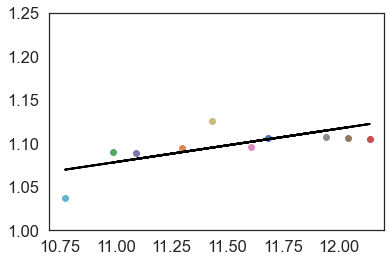

In [29]:
for i in np.arange(11):
    plt.scatter(wide_mean['PVALB'].values[i]+wide_mean['SST'].values[i], child['H'].values[i])
df_x = pd.DataFrame(wide_mean['PVALB'].values+wide_mean['SST'].values)
df_y = pd.DataFrame(child['H'].values)
mod = LinearRegression()
mod_lin = mod.fit(df_x, df_y)
y_lin_fit = mod_lin.predict(df_x)
r2_lin = mod.score(df_x, df_y)
plt.plot(df_x, y_lin_fit, color = '#000000', linewidth=2)
print(r2_lin)
X = sm.add_constant(wide_mean['PVALB'].values+wide_mean['SST'].values)
results = sm.OLS([float(x) for x in child['H'].values], X).fit()
print(results.summary())
plt.ylim([1,1.25])
plt.xlim([10.7,12.2])
#plt.savefig('../figures/Fig2_childPV+SST.eps',  format='eps', bbox_inches='tight')